Reproduce plots from: 
The Representation of Sea Salt Aerosols and Their Role in Polar Climate Within CMIP6

GOAL:
- make familiar with Wilcoxon test and dask
- compare parallelized version



(0) Define and regrid the data on a common grid

In [1]:
import os
os.getcwd()

'/home/jovyan/ArditArifi'

In [2]:
source_path="/home/jovyan/prepared-data/POLAR_EMISS_DATA/CMIP6"
processed_path="/home/jovyan/student-storages/GROUP3/ArditArifi/CMIP6_processed"
output_path="/home/jovyan/student-storages/GROUP3/ArditArifi/CMIP6_output"

! mkdir -p {processed_path}
! mkdir -p {output_path}

In [3]:
grid_description = """
gridtype = lonlat
xsize = 120
ysize = 90
xfirst = 0.0
xinc = 3.0
yfirst = -90.0
yinc = 2.0
"""

grid_file = "grid_3x2.txt"

# Save the grid description to a file
with open(grid_file, "w") as grid_file:
    grid_file.write(grid_description)

print("Grid description file created: grid_3x2.txt")

Grid description file created: grid_3x2.txt


In [4]:
var = "tas"
! ./reproduce.sh {source_path} {output_path} {var}

cdo    remapbil: Bilinear weights from lonlat (144x143) to lonlat (120x90) grid
cdo    remapbil: Processed 7413120 values from 1 variable over 360 timesteps [0.83s 86MB].
Regridded: /home/jovyan/prepared-data/POLAR_EMISS_DATA/CMIP6/tas_Amon_IPSL-CM6A-LR-INCA_piClim-2xss_r1i1p1f1_gr_185001-187912.nc -> /home/jovyan/student-storages/GROUP3/ArditArifi/CMIP6_output/tas_Amon_IPSL-CM6A-LR-INCA_piClim-2xss_r1i1p1f1_gr_185001-187912.nc
cdo    remapbil: Bilinear weights from lonlat (144x143) to lonlat (120x90) grid
cdo    remapbil: Processed 7413120 values from 1 variable over 360 timesteps [0.75s 87MB].
Regridded: /home/jovyan/prepared-data/POLAR_EMISS_DATA/CMIP6/tas_Amon_IPSL-CM6A-LR-INCA_piClim-control_r1i1p1f1_gr_185001-187912.nc -> /home/jovyan/student-storages/GROUP3/ArditArifi/CMIP6_output/tas_Amon_IPSL-CM6A-LR-INCA_piClim-control_r1i1p1f1_gr_185001-187912.nc
cdo    remapbil: Bilinear weights from lonlat (144x96) to lonlat (120x90) grid
cdo    remapbil: Processed 1658880 values from 1 va

(1) Reproduce Fig 10.

In [7]:
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as colors
from scipy.stats import pearsonr, norm, wilcoxon

model = "NorESM2"
var = "rtmt"

# Load data
piClim_2xss = xr.open_mfdataset(f"{source_path}/rtmt*{model}*piClim-2xss*.nc", combine="by_coords")
piClim_control = xr.open_mfdataset(f"{source_path}/rtmt*{model}*piClim-control*.nc", combine="by_coords")

# Calculate bias
bias = piClim_2xss[var] - piClim_control[var]

In [8]:
from scipy.stats import pearsonr, norm, wilcoxon


# Winter / Summer (time-mean)
bias_winter = bias.where((bias["time.month"] > 11) | (bias["time.month"] < 3), drop=True)
wilco_test_winter = wilcoxon(bias_winter.values).pvalue
wilco_mask_winter = wilco_test_winter.copy()
wilco_mask_winter = xr.where(wilco_mask_winter<0.1, np.nan, 1)
bias_winter = bias_winter.mean(dim="time")

bias_summer = bias.where((bias["time.month"] > 5) & (bias["time.month"] < 9), drop=True)
wilco_test_summer = wilcoxon(bias_summer.values).pvalue
wilco_mask_summer = wilco_test_summer.copy()
wilco_mask_summer = xr.where(wilco_mask_summer<0.1, np.nan, 1)
bias_summer = bias_summer.mean(dim="time")


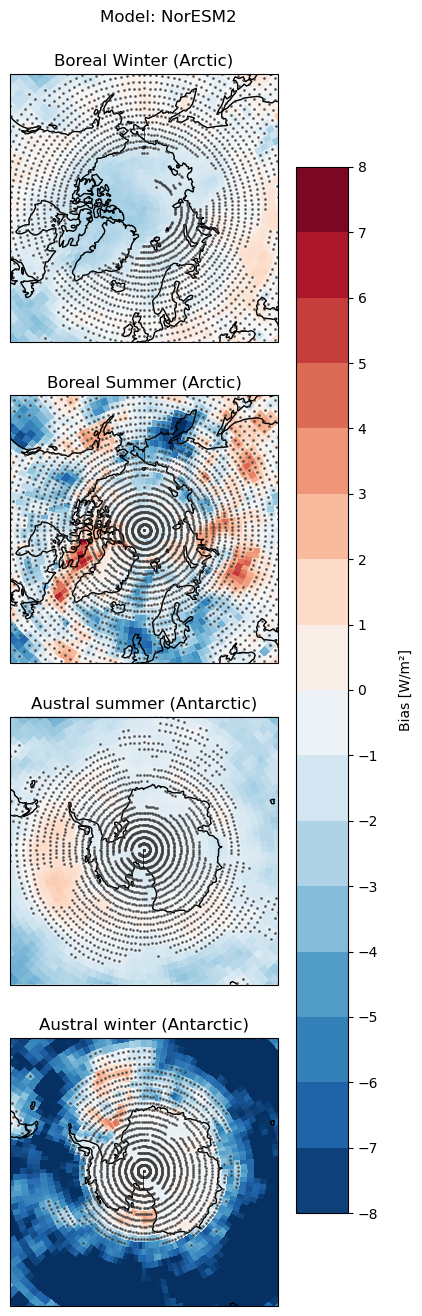

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

###############################
# Create Figure and Subplots
###############################
fig, axes = plt.subplots(
    nrows=4, ncols=1,
    figsize=(4.5, 16),
    subplot_kw={"projection": ccrs.NorthPolarStereo()}
)
fig.suptitle(f"Model: {model}", y=0.92)

axes = axes.flatten()

# Add coastlines to all subplots upfront
for ax in axes:
    ax.coastlines()

###############################
# Set Color Range and Levels
###############################
vmin, vmax = -8, 8
levels = np.arange(vmin, vmax + 1, 1)
norm = colors.BoundaryNorm(boundaries=levels, ncolors=len(levels) - 1, clip=True)

###############################
# ARCTIC SUBPLOTS (Top 2)
###############################

# 1) Boreal Winter (Arctic)
axes[0].set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())  # Limit to lat 50N-90N
axes[0].add_feature(cartopy.feature.LAND, edgecolor='black', zorder=10,
                    facecolor=(1,1,1,0), linewidth=0.25)
p = bias_winter.plot(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False
)
axes[0].set_title("Boreal Winter (Arctic)")

# Plot the Wilcoxon mask as scatter
x, y = np.meshgrid(bias_winter.lon, bias_winter.lat)
mask_nan = np.isnan(wilco_mask_winter)  # True where mask is NaN
x[mask_nan] = np.nan
y[mask_nan] = np.nan
axes[0].plot(
    x, y,
    linewidth=0,
    marker='o',
    markersize=1,
    markerfacecolor=(0.25,0.25,0.25,0.75),
    markeredgecolor=(0.25,0.25,0.25,0.75),
    transform=ccrs.PlateCarree()
)

# 2) Boreal Summer (Arctic)
axes[1].set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
axes[1].add_feature(cartopy.feature.LAND, edgecolor='black', zorder=10,
                    facecolor=(1,1,1,0), linewidth=0.25)
bias_summer.plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False
)
axes[1].set_title("Boreal Summer (Arctic)")

# Wilcoxon mask for summer
x_s, y_s = np.meshgrid(bias_summer.lon, bias_summer.lat)
mask_nan_s = np.isnan(wilco_mask_summer)
x_s[mask_nan_s] = np.nan
y_s[mask_nan_s] = np.nan
axes[1].plot(
    x_s, y_s,
    linewidth=0,
    marker='o',
    markersize=1,
    markerfacecolor=(0.25,0.25,0.25,0.75),
    markeredgecolor=(0.25,0.25,0.25,0.75),
    transform=ccrs.PlateCarree()
)

###############################
# ANTARCTIC SUBPLOTS (Bottom 2)
###############################

# 3) Austral Winter (Antarctic)
axes[2].projection = ccrs.SouthPolarStereo()
axes[2].set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())  # Limit to lat -90 to -50
axes[2].add_feature(cartopy.feature.LAND, edgecolor='black', zorder=10,
                    facecolor=(1,1,1,0), linewidth=0.25)
bias_summer.plot(
    ax=axes[2],
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False
)
axes[2].set_title("Austral summer (Antarctic)")

# You could optionally show a different Wilcoxon mask if you have Antarctic data separated
# Here we reuse wilco_mask_summer for demonstration
x_wi, y_wi = np.meshgrid(bias_summer.lon, bias_summer.lat)
mask_nan_wi = np.isnan(wilco_mask_summer)
x_wi[mask_nan_wi] = np.nan
y_wi[mask_nan_wi] = np.nan
axes[2].plot(
    x_wi, y_wi,
    linewidth=0,
    marker='o',
    markersize=1,
    markerfacecolor=(0.25,0.25,0.25,0.75),
    markeredgecolor=(0.25,0.25,0.25,0.75),
    transform=ccrs.PlateCarree()
)

# 4) Austral Summer (Antarctic)
axes[3].projection = ccrs.SouthPolarStereo()
axes[3].set_extent([-180, 180, -90, -50], crs=ccrs.PlateCarree())
axes[3].add_feature(cartopy.feature.LAND, edgecolor='black', zorder=10,
                    facecolor=(1,1,1,0), linewidth=0.25)
bias_winter.plot(
    ax=axes[3],
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False
)
axes[3].set_title("Austral winter (Antarctic)")

# Reuse winter mask or a separate Antarctica mask if you have it
x_su, y_su = np.meshgrid(bias_winter.lon, bias_winter.lat)
mask_nan_su = np.isnan(wilco_mask_winter)
x_su[mask_nan_su] = np.nan
y_su[mask_nan_su] = np.nan
axes[3].plot(
    x_su, y_su,
    linewidth=0,
    marker='o',
    markersize=1,
    markerfacecolor=(0.25,0.25,0.25,0.75),
    markeredgecolor=(0.25,0.25,0.25,0.75),
    transform=ccrs.PlateCarree()
)

###############################
# Shared Colorbar
###############################
cbar = fig.colorbar(
    p,
    ax=axes,
    orientation="vertical",
    ticks=levels,
    boundaries=levels,
    location="right"
)
cbar.set_label("Bias [W/m²]", labelpad=15)
cbar.ax.yaxis.set_label_position("right")
cbar.ax.yaxis.tick_right()

plt.savefig(f'rtmt_bias_{model}.png', bbox_inches='tight')